In [1]:
import pandas as pd
import re
import os
import glob
import snapatac2 as snap

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import utils
import subprocess

In [3]:
df_deg_glut = pd.read_csv('/home/junyichen/code/scmmd/data/degs/Memento_Glut_DEGs_each_region_diff_gender_v1.csv',index_col=0)
df_deg_gaba = pd.read_csv('/home/junyichen/code/scmmd/data/degs/Memento_GABA_DEGs_each_region_diff_gender_v1.csv',index_col=0)
df_deg_glut['ctname'] = df_deg_glut['region'] + '_Glut'
df_deg_gaba['ctname'] = df_deg_gaba['region'] + '_GABA'
df_deg = pd.concat([df_deg_glut,df_deg_gaba],axis=0,ignore_index=True)

In [4]:
df_deg_select = df_deg[(df_deg.de_pval<0.05) & (df_deg.gender=="M") & (df_deg.region.isin(['AMY','HIP','PFC']))]

In [5]:
df_deg_select['condition'] = 'MW'
df_deg_select.loc[df_deg_select.de_coef>0,'condition'] = 'MC'

/tmp/ipykernel_2450363/3437822688.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_deg_select['condition'] = 'MW'


In [6]:
df_wil = pd.read_csv('/data2st1/junyi/output/atac0416/dar/region_nt/df_annotattion_wilcoxon.csv')
df_mementob_old = pd.read_csv('/data2st1/junyi/output/atac0416/cCRE/df_deg_mento_annotated.csv')

In [7]:
df_memento_cov = pd.read_csv('/data2st1/junyi/output/atac0416/dar/region_nt/mementoht_dar_annotated.csv')
df_memento_cov = df_memento_cov[df_memento_cov.de_pval<0.05]

In [8]:
df_memento_cr = pd.read_csv('/data2st1/junyi/output/atac0526/dar/region_nt/mementob_dar_annotated.csv')
df_memento_cr = df_memento_cr[df_memento_cr.de_pval<0.05]
df_memento_dbatch = pd.read_csv('/data2st1/junyi/output/atac0526/dar/region_nt/mementoht_dar_annotated.csv')
df_memento_dbatch = df_memento_dbatch[df_memento_dbatch.de_pval<0.05]

In [9]:
df_result_all = pd.DataFrame()

In [10]:
df_wil.rename(columns={'gene_name': 'gene'}, inplace=True)
d_degdar_wil = df_wil.merge(df_deg_select,how='inner',left_on=['ctname','condition','gene'],right_on=['ctname','condition','gene'],suffixes=('_atac', '_sc'))
d_degdar_wil.sort_values(by='condition', ascending=False, inplace=True)
d_degdar_wil.loc[d_degdar_wil.condition=='MW','logfoldchanges'] = d_degdar_wil.loc[d_degdar_wil.condition=='MW','logfoldchanges']*-1
for ctname in d_degdar_wil.ctname.unique():
    df_ct = d_degdar_wil[d_degdar_wil.ctname == ctname]
    df_s_deg = df_deg[df_deg.ctname == ctname]

    corr = df_ct[['logfoldchanges', 'de_coef']].corr().iloc[0, 1]
    IoU = len(df_ct.drop_duplicates(['gene'])) / len(set(df_s_deg.gene).union(set(df_wil.gene)))

    row = pd.DataFrame({
        'ctname': ctname,
        'corr': corr,
        'IoU': IoU,
        'size': len(df_ct),
        'method': "wilcoxon"
    }, index=[0])
    df_result_all = pd.concat([df_result_all, row], ignore_index=True)
    print(f'Correlation for {ctname}: {corr:.2f},size={len(df_ct)}, IoU={IoU:.2f}')

Correlation for PFC_Glut: 0.04,size=6834, IoU=0.05
Correlation for PFC_GABA: 0.45,size=72, IoU=0.00
Correlation for AMY_Glut: 0.52,size=143, IoU=0.01
Correlation for HIP_Glut: -0.06,size=1466, IoU=0.05
Correlation for AMY_GABA: 0.03,size=185, IoU=0.01
Correlation for HIP_GABA: nan,size=1, IoU=0.00


In [11]:
d_degdar_wil[['logfoldchanges','de_coef']].corr()

,logfoldchanges,de_coef
logfoldchanges,1.000000,0.636427
de_coef,0.636427,1.000000


In [12]:
df_memento_cov.rename(columns={'gene_name': 'gene'}, inplace=True)
df_degmemento_cov = df_memento_cov.merge(df_deg_select, how='inner', left_on=['ctname', 'condition', 'gene'], right_on=['ctname', 'condition', 'gene'], suffixes=('_atac', '_sc'))
for ctname in df_degmemento_cov.ctname.unique():
    df_ct = df_degmemento_cov[df_degmemento_cov.ctname == ctname]
    df_s_deg = df_deg[df_deg.ctname == ctname]
    df_s_dar = df_memento_cov[df_memento_cov.ctname == ctname]
    corr = df_ct[['de_coef_atac', 'de_coef_sc']].corr(method='pearson').iloc[0, 1]
    IoU = len(df_ct.drop_duplicates(['gene'])) / len(set(df_s_deg.gene).union(set(df_s_dar.gene)))
    row = pd.DataFrame({
        'ctname': ctname,
        'corr': corr,
        'IoU': IoU,
        'size': len(df_ct),
        'method': "memento_cr_cov"
    }, index=[0])
    df_result_all = pd.concat([df_result_all, row], ignore_index=True)
    print(f'Correlation for {ctname}: {corr:.2f},size={len(df_ct.drop_duplicates(subset=["gene"]))}, IoU={IoU:.2f}')

Correlation for PFC_Glut: 0.02,size=3624, IoU=0.23
Correlation for PFC_GABA: 0.02,size=1471, IoU=0.13
Correlation for HIP_Glut: 0.54,size=1606, IoU=0.12
Correlation for HIP_GABA: 0.01,size=966, IoU=0.10
Correlation for AMY_GABA: 0.48,size=974, IoU=0.09
Correlation for AMY_Glut: 0.79,size=1207, IoU=0.09


In [13]:
df_degmemento_cov[['de_coef_atac','de_coef_sc']].corr()

,de_coef_atac,de_coef_sc
de_coef_atac,1.000000,0.317278
de_coef_sc,0.317278,1.000000


In [14]:
df_memento_cr.rename(columns={'gene_name': 'gene'}, inplace=True)
df_degmemento_cr = df_memento_cr.merge(df_deg_select, how='inner', left_on=['ctname', 'condition', 'gene'], right_on=['ctname', 'condition', 'gene'], suffixes=('_atac', '_sc'))
for ctname in df_degmemento_cr.ctname.unique():
    df_ct = df_degmemento_cr[df_degmemento_cr.ctname == ctname]
    df_s_deg = df_deg[df_deg.ctname == ctname]
    df_s_dar = df_memento_cr[df_memento_cr.ctname == ctname]
    corr = df_ct[['de_coef_atac', 'de_coef_sc']].corr(method='pearson').iloc[0, 1]
    IoU = len(df_ct.drop_duplicates(['gene'])) / len(set(df_s_deg.gene).union(set(df_s_dar.gene)))
    print(f'Correlation for {ctname}: {corr:.2f},size={len(df_ct.drop_duplicates(subset=["gene"]))}, IoU={IoU:.2f}')
    row = pd.DataFrame({
        'ctname': ctname,
        'corr': corr,
        'IoU': IoU,
        'size': len(df_ct),
        'method': "memento_cr"
    }, index=[0])
    df_result_all = pd.concat([df_result_all, row], ignore_index=True)
df_memento_dbatch.rename(columns={'gene_name': 'gene'}, inplace=True)

Correlation for PFC_Glut: 0.27,size=1285, IoU=0.07
Correlation for PFC_GABA: 0.72,size=407, IoU=0.03
Correlation for HIP_GABA: 0.03,size=907, IoU=0.09
Correlation for HIP_Glut: 0.71,size=1924, IoU=0.13
Correlation for AMY_Glut: 0.74,size=2085, IoU=0.14
Correlation for AMY_GABA: 0.27,size=2087, IoU=0.18


In [15]:
df_memento_cr.ctname.isin(set(df_degmemento_cr.ctname))

0         False
1         False
2         False
3         False
4         False
          ...  
441249     True
441250     True
441251     True
441252     True
441253     True
Name: ctname, Length: 166092, dtype: bool

In [16]:

df_memnto_cr_repeat = df_memento_cr.loc[df_memento_cr.ctname.isin(set(df_degmemento_cr.ctname)),['ctname','condition','gene']].groupby(['condition','gene']).nunique().reset_index()

In [17]:
df_memnto_cr_repeat.rename(columns={'ctname': 'n_celltype'}, inplace=True)

In [18]:
df_memnto_cr_ct = df_memento_cr.loc[df_memento_cr.ctname.isin(set(df_degmemento_cr.ctname)),['ctname','condition','gene']].groupby(
    ['condition','gene']).aggregate(lambda x: '/'.join(set(x))).reset_index()

In [19]:
df_memnto_cr_repeat = df_memnto_cr_ct.merge(df_memnto_cr_repeat, how='inner', on=['condition', 'gene'])

In [20]:
df_memnto_cr_repeat.sort_values(by='n_celltype', ascending=False, inplace=True)

In [21]:
df_memnto_cr_repeat.rename(columns={'ctname': 'darct'}, inplace=True)

In [22]:
df_memento_cr.merge(df_memnto_cr_repeat, how='left', on=['condition', 'gene']).to_csv('/data2st1/junyi/output/atac0526/dar/region_nt/mementob_dar_noccur.csv', index=False)

In [23]:
df_degmemento_cr_repeat = df_degmemento_cr.loc[:,['ctname','condition','gene']].groupby(['condition','gene']).nunique().reset_index().sort_values(by='ctname', ascending=False)

In [24]:
df_degmemento_cr_repeat

,condition,gene,ctname
1343,MC,Garnl3,6
5044,MW,Mical2,5
995,MC,Drg1,5
3149,MC,Sergef,5
3557,MC,Tef,5
...,...,...,...
2532,MC,Peli3,1
2531,MC,Peli2,1
2530,MC,Peli1,1
2529,MC,Peg3,1


In [25]:
df_memnto_cr_repeat.value_counts("n_celltype").reset_index('n_celltype').rename(columns={0: 'n_cell'})

,n_celltype,n_cell
0,1,13756
1,2,10918
2,3,4907
3,4,1963
4,5,204
5,6,27


,n_cell
n_celltype,
1,13756
2,10918
3,4907
4,1963
5,204
6,27


<Axes: ylabel='n_cell'>

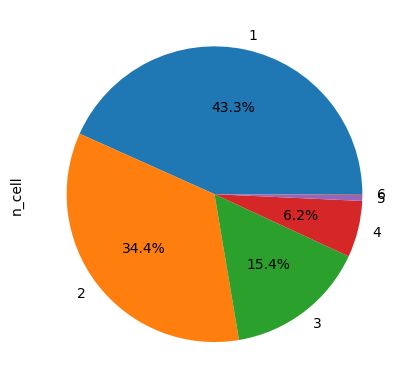

In [36]:
df_memnto_cr_repeat.value_counts("n_celltype").reset_index('n_celltype').rename(columns={0: 'n_cell'}).set_index('n_celltype').plot.pie(
    y='n_cell',
    autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
    legend=False
)


In [27]:
df_degmemento_cr_repeat

,condition,gene,ctname
1343,MC,Garnl3,6
5044,MW,Mical2,5
995,MC,Drg1,5
3149,MC,Sergef,5
3557,MC,Tef,5
...,...,...,...
2532,MC,Peli3,1
2531,MC,Peli2,1
2530,MC,Peli1,1
2529,MC,Peg3,1


In [28]:
df_degmemento_cr.loc[:,['ctname','condition','gene']].groupby(['condition','gene']).count().reset_index()

,condition,gene,ctname
0,MC,1110038F14Rik,2
1,MC,1110059E24Rik,1
2,MC,1500004A13Rik,3
3,MC,1500009L16Rik,1
4,MC,1500011B03Rik,1
...,...,...,...
5923,MW,Znhit1,1
5924,MW,Znrf2,1
5925,MW,Zscan22,2
5926,MW,Zswim6,1


In [29]:
df_memento_dbatch.rename(columns={'gene_name': 'gene'}, inplace=True)
df_degmemento_dbatch = df_memento_dbatch.merge(df_deg_select, how='inner', left_on=['ctname', 'condition', 'gene'], right_on=['ctname', 'condition', 'gene'], suffixes=('_atac', '_sc'))
for ctname in df_degmemento_dbatch.ctname.unique():
    df_ct = df_degmemento_dbatch[df_degmemento_dbatch.ctname == ctname]
    df_s_deg = df_deg[df_deg.ctname == ctname]
    df_s_dar = df_memento_dbatch[df_memento_dbatch.ctname == ctname]
    corr = df_ct[['de_coef_atac', 'de_coef_sc']].corr(method='pearson').iloc[0, 1]
    IoU = len(df_ct.drop_duplicates(['gene'])) / len(set(df_s_deg.gene).union(set(df_s_dar.gene)))
    row = pd.DataFrame({
        'ctname': ctname,
        'corr': corr,
        'IoU': IoU,
        'size': len(df_ct),
        'method': "memento_batch_cov"
    }, index=[0])
    df_result_all = pd.concat([df_result_all, row], ignore_index=True)
    print(f'Correlation for {ctname}: {corr:.2f},size={len(df_ct.drop_duplicates(subset=["gene"]))}, IoU={IoU:.2f}')

Correlation for PFC_Glut: 0.26,size=1189, IoU=0.07
Correlation for PFC_GABA: 0.68,size=358, IoU=0.03
Correlation for HIP_Glut: 0.72,size=1944, IoU=0.13
Correlation for HIP_GABA: 0.02,size=902, IoU=0.09
Correlation for AMY_GABA: 0.25,size=2067, IoU=0.18
Correlation for AMY_Glut: 0.74,size=2101, IoU=0.14


In [30]:
df_mementob_old.rename(columns={'gene_name': 'gene'}, inplace=True)
df_degmementob_old = df_mementob_old.merge(df_deg_select, how='inner', left_on=['ctname', 'condition', 'gene'], right_on=['ctname', 'condition', 'gene'], suffixes=('_atac', '_sc'))
for ctname in df_degmementob_old.ctname.unique():
    df_ct = df_degmementob_old[df_degmementob_old.ctname == ctname]
    df_s_deg = df_deg[df_deg.ctname == ctname]
    df_s_dar = df_mementob_old[df_mementob_old.ctname == ctname]
    corr = df_ct[['de_coef_atac', 'de_coef_sc']].corr(method='pearson').iloc[0, 1]
    IoU = len(df_ct.drop_duplicates(['gene'])) / len(set(df_s_deg.gene).union(set(df_s_dar.gene)))
    row = pd.DataFrame({
        'ctname': ctname,
        'corr': corr,
        'IoU': IoU,
        'size': len(df_ct),
        'method': "memento"
    }, index=[0])
    df_result_all = pd.concat([df_result_all, row], ignore_index=True)
    print(f'Correlation for {ctname}: {corr:.2f},size={len(df_ct.drop_duplicates(subset=["gene"]))}, IoU={IoU:.2f}')

Correlation for PFC_Glut: 0.26,size=1267, IoU=0.07
Correlation for PFC_GABA: 0.69,size=404, IoU=0.03
Correlation for HIP_GABA: 0.01,size=941, IoU=0.09
Correlation for HIP_Glut: 0.71,size=1904, IoU=0.13
Correlation for AMY_Glut: 0.74,size=2108, IoU=0.15
Correlation for AMY_GABA: 0.25,size=2099, IoU=0.18


<Axes: xlabel='ctname', ylabel='corr'>

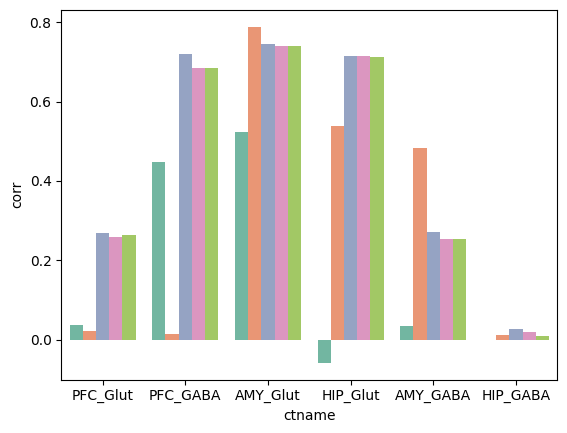

In [33]:
sns.barplot(
    data=df_result_all,
    x='ctname',
    y='corr',
    hue='method',
    legend=False,
    palette=sns.color_palette("Set2", n_colors=len(df_result_all.method.unique()))
)

<Axes: xlabel='ctname', ylabel='IoU'>

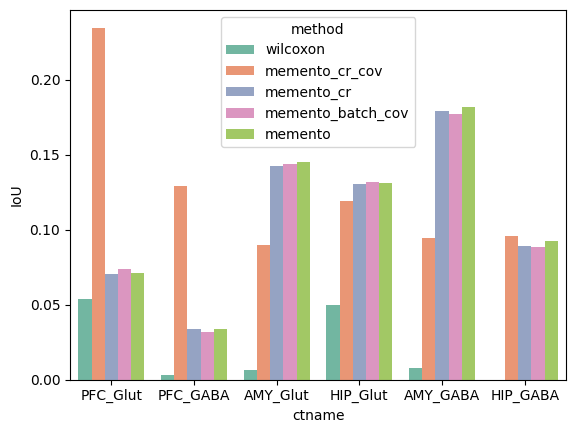

In [32]:
sns.barplot(
    data=df_result_all,
    x='ctname',
    y='IoU',
    hue='method',
    palette=sns.color_palette("Set2", n_colors=len(df_result_all.method.unique()))
)

In [38]:
df_memento_cr

,names,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,ctname,region,...,gene_id,gstart,gend,strand,annotation_x,distance,de_pval_adj,primary_region,secondary_region,ctname_con
0,chr2:98662628-98663129,stim,0.297648,0.040250,1.275518e-13,-0.126407,0.107848,0.234857,Immune,PFC,...,ENSMUSG00000075015.3,98662236,98664083,+,genebody,0,3.038415e-12,exon,LINE,Immune_MC
1,chrX:143482812-143483313,stim,0.367096,0.049646,1.308574e-13,0.010504,0.125507,0.992527,Immune,PFC,...,ENSMUSG00000031284.16,143518590,143797796,+,genebody,35278,3.114843e-12,distal,LINE,Immune_MC
2,chr6:103648949-103649450,stim,0.297753,0.040198,1.474284e-13,-0.144116,0.094564,0.110749,Immune,PFC,...,ENSMUSG00000030077.11,103510585,103750211,+,genebody,0,3.496496e-12,intron,LINE,Immune_MC
3,chr2:98662045-98662546,stim,0.314090,0.042905,2.253055e-13,-0.469675,0.251926,0.074096,Immune,PFC,...,ENSMUSG00000075015.3,98662236,98664083,+,genebody,0,5.274371e-12,exon,repeat,Immune_MC
4,chr12:20815539-20816040,stim,0.679751,0.098147,5.078591e-12,-0.045391,0.226588,0.728508,Immune,PFC,...,ENSMUSG00000099759.1,20804380,20815779,-,genebody,0,1.072659e-10,exon,cpg,Immune_MC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441249,chr13:98316774-98317275,stim,-0.093560,0.047568,4.964940e-02,0.077941,0.208111,0.741855,AMY_GABA,AMY,...,ENSMUSG00000048603.8,98316421,98324415,+,genebody,0,1.344347e-01,promoter,cpg,AMY_GABA_MW
441250,chr7:80688678-80689179,stim,-0.104519,0.053277,4.972339e-02,-0.302131,0.229897,0.191148,AMY_GABA,AMY,...,ENSMUSG00000030527.15,80586626,80688877,-,genebody,0,1.345883e-01,promoter,cpg,AMY_GABA_MW
441251,chr17:66123319-66123820,stim,-0.100798,0.053496,4.980623e-02,0.086841,0.205283,0.619451,AMY_GABA,AMY,...,ENSMUSG00000035842.10,66123519,66152174,+,genebody,0,1.347595e-01,UTR,cpg,AMY_GABA_MW
441252,chr5:57716510-57717011,stim,-0.139860,0.070286,4.997954e-02,-0.236434,0.346212,0.444463,AMY_GABA,AMY,...,ENSMUSG00000097216.3,57570081,57720201,-,genebody,0,1.351111e-01,exon,NaN,AMY_GABA_MW


In [65]:
df_memento_cr['regulation'] = df_memento_cr['condition'].apply(lambda x: 'Up' if x == 'MC' else 'Down')

In [66]:
df_memento_cr['celltype.L1'] = df_memento_cr['ctname'].apply(lambda x: x.split('_')[-1])

In [84]:
df_memento_cr.columns

Index(['names', 'tx', 'de_coef', 'de_se', 'de_pval', 'dv_coef', 'dv_se',
       'dv_pval', 'ctname', 'region', 'condition', 'gene', 'gene_id', 'gstart',
       'gend', 'strand', 'annotation_x', 'distance', 'de_pval_adj',
       'primary_region', 'secondary_region', 'ctname_con', 'regularion',
       'regulation', 'celltype.L1'],
      dtype='object')

In [85]:
df_memento_cr.drop(['regularion'],axis=1,inplace=True)

In [87]:
df_memento_cr.merge(df_memnto_cr_repeat, how='left', on=['condition', 'gene']).rename(columns={'darct': 'Neu_subtype','n_celltype':'#Neuron_type'}).to_csv('/data2st1/junyi/output/atac0526/dar/region_nt/mementob_dar_noccur.csv', index=False)

/tmp/ipykernel_2450363/4174702003.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Celltype Proportions per Sample'}, xlabel='ctname_con', ylabel='Proportion (%)'>)

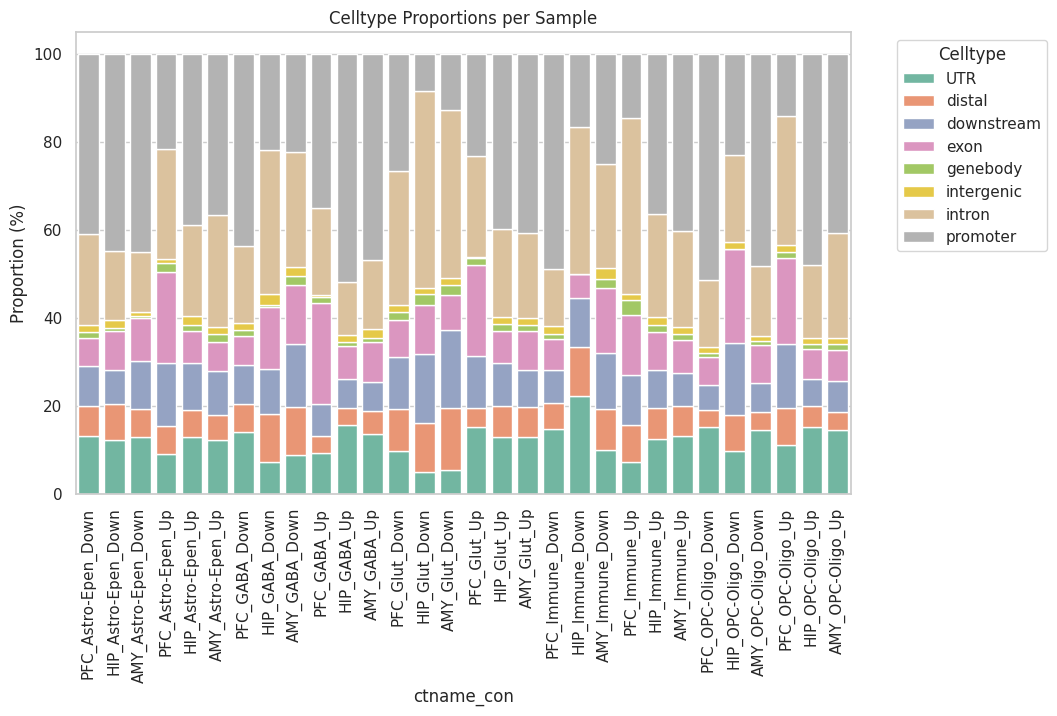

In [75]:
def plot_stack_prop(df,x=None, y='proportion',pro_col='celltype.L1',color_palette=sns.color_palette("Set2"), figsize=(10, 6),x_order=None, **kwargs):
    counts = df.groupby([x, pro_col]).size().unstack(fill_value=0)
    # If x_order is provided, sort the index of counts
    if x_order is not None:
        counts = counts.loc[x_order]
    df_prop = counts.div(counts.sum(axis=1), axis=0) * 100
    df_prop = df_prop.reset_index().melt(id_vars=x, var_name=pro_col, value_name=y)
    fig, ax = plt.subplots(figsize=figsize)
    sns.set(style="whitegrid")
    # Initialize bottom positions for stacking
        # Sort the dataframe by the specified order by the column of sample name
    bottom = pd.Series([0] * len(df_prop[x].unique()), index=df_prop[x].unique())
    # Plot each celltype layer
    for i, celltype in enumerate(df_prop[pro_col].unique()):
        subset = df_prop[df_prop[pro_col] == celltype]
        sns.barplot(
            x=x, y=y, data=subset,
            label=celltype, bottom=bottom[subset[x]],
            color=color_palette[i]
        )
        bottom += subset.set_index(x)[y].reindex(bottom.index, fill_value=0)
    ax.set_title('Celltype Proportions per Sample')
    ax.set_ylabel('Proportion (%)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.legend(title='Celltype', bbox_to_anchor=(1.05, 1))
    return fig,ax

#order = meta_atac.sort_values('Region')['sample'].unique()
df_memento_cr['ctname_con'] = df_memento_cr['region'].astype(str) +"_"+ df_memento_cr['ctname'].str.split('_').str[-1].astype(str) + "_" + df_memento_cr['regulation'].astype(str)
order = df_memento_cr.sort_values(by=['celltype.L1','regulation']).drop_duplicates(['ctname_con']).ctname_con.to_list()
plot_stack_prop(df_memento_cr,x='ctname_con', y='proportion',pro_col="primary_region",x_order=order, figsize=(10, 6))

In [44]:
df_memento_cr

,names,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,ctname,region,...,gene_id,gstart,gend,strand,annotation_x,distance,de_pval_adj,primary_region,secondary_region,ctname_con
0,chr2:98662628-98663129,stim,0.297648,0.040250,1.275518e-13,-0.126407,0.107848,0.234857,Immune,PFC,...,ENSMUSG00000075015.3,98662236,98664083,+,genebody,0,3.038415e-12,exon,LINE,PFC_Immune_MC
1,chrX:143482812-143483313,stim,0.367096,0.049646,1.308574e-13,0.010504,0.125507,0.992527,Immune,PFC,...,ENSMUSG00000031284.16,143518590,143797796,+,genebody,35278,3.114843e-12,distal,LINE,PFC_Immune_MC
2,chr6:103648949-103649450,stim,0.297753,0.040198,1.474284e-13,-0.144116,0.094564,0.110749,Immune,PFC,...,ENSMUSG00000030077.11,103510585,103750211,+,genebody,0,3.496496e-12,intron,LINE,PFC_Immune_MC
3,chr2:98662045-98662546,stim,0.314090,0.042905,2.253055e-13,-0.469675,0.251926,0.074096,Immune,PFC,...,ENSMUSG00000075015.3,98662236,98664083,+,genebody,0,5.274371e-12,exon,repeat,PFC_Immune_MC
4,chr12:20815539-20816040,stim,0.679751,0.098147,5.078591e-12,-0.045391,0.226588,0.728508,Immune,PFC,...,ENSMUSG00000099759.1,20804380,20815779,-,genebody,0,1.072659e-10,exon,cpg,PFC_Immune_MC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441249,chr13:98316774-98317275,stim,-0.093560,0.047568,4.964940e-02,0.077941,0.208111,0.741855,AMY_GABA,AMY,...,ENSMUSG00000048603.8,98316421,98324415,+,genebody,0,1.344347e-01,promoter,cpg,AMY_AMY_GABA_MW
441250,chr7:80688678-80689179,stim,-0.104519,0.053277,4.972339e-02,-0.302131,0.229897,0.191148,AMY_GABA,AMY,...,ENSMUSG00000030527.15,80586626,80688877,-,genebody,0,1.345883e-01,promoter,cpg,AMY_AMY_GABA_MW
441251,chr17:66123319-66123820,stim,-0.100798,0.053496,4.980623e-02,0.086841,0.205283,0.619451,AMY_GABA,AMY,...,ENSMUSG00000035842.10,66123519,66152174,+,genebody,0,1.347595e-01,UTR,cpg,AMY_AMY_GABA_MW
441252,chr5:57716510-57717011,stim,-0.139860,0.070286,4.997954e-02,-0.236434,0.346212,0.444463,AMY_GABA,AMY,...,ENSMUSG00000097216.3,57570081,57720201,-,genebody,0,1.351111e-01,exon,NaN,AMY_AMY_GABA_MW


/tmp/ipykernel_2450363/4174702003.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Celltype Proportions per Sample'}, xlabel='ctname_con', ylabel='Proportion (%)'>)

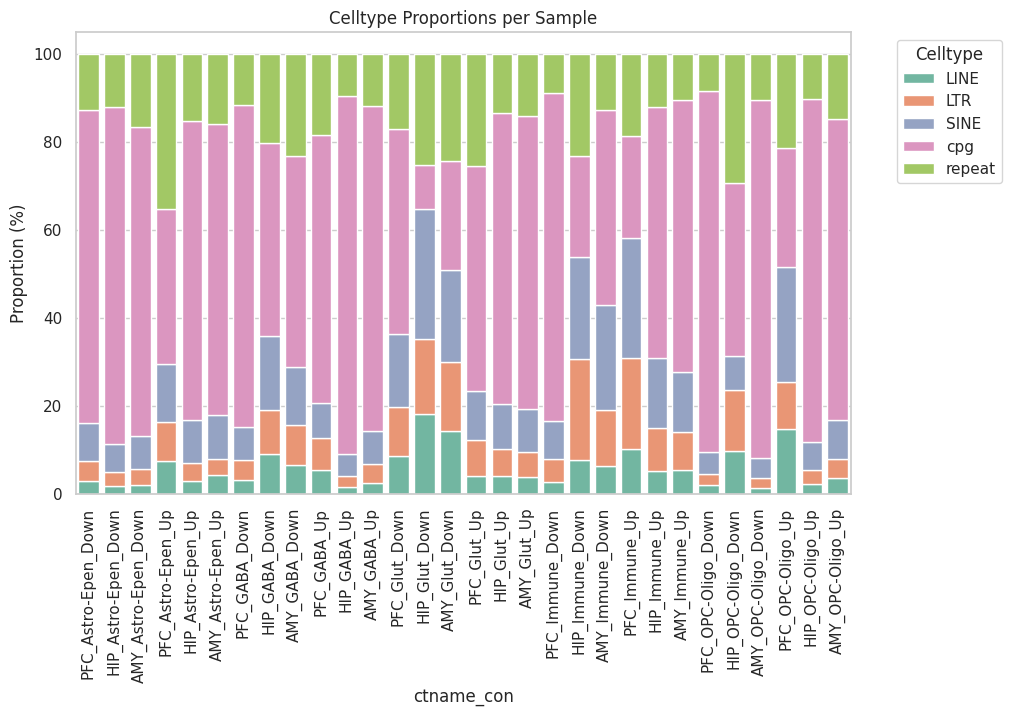

In [77]:
plot_stack_prop(df_memento_cr,x='ctname_con', y='proportion',pro_col="secondary_region",x_order=order, figsize=(10, 6))

In [89]:
df_memento_cr.to_csv('/data2st1/junyi/output/atac0526/dar/region_nt/mementob_cr_annotated.csv', index=False)

In [91]:
celltypes = ['Glut', 'GABA']
regions = ['AMY', 'HIP', 'PFC']
condtion = ['MC', 'MW']

for celltype in celltypes:
    for region in regions:
        for con in condtion:
        # read the network genertaed by CICRE
            region2 = region+"_"+region
            df_network = pd.read_csv(f'/data1st2/junyi/output/atac0416/cicre/region_nt/{region2}_{celltype}_{con}_circe_network.csv', index_col=0)
            distance = df_network.Peak1.str.split('_').str[1].astype(int) -df_network.Peak2.str.split('_').str[1].astype(int)
            distance[distance.abs()<500_000].abs().hist(bins=100)
            plt.axvline(x=np.median(distance[distance.abs()<500_000].abs()), color='r', linestyle='-' )  # y=position, color, linestyle
        # plt.text(np.median(distance[distance.abs()<500_000].abs()) +10000, 25000, , color='k')  # Position text at (x=1, y=5.1)
            plt.title(f'Median distance:{np.median(distance[distance.abs()<500_000].abs())}')
            plt.savefig(f'/data1st2/junyi/output/atac0416/cicre/region_nt/{region2}_{celltype}_{con}_circe_network_distance.png')
            plt.close()


In [92]:
df_network

,Peak1,Peak2,score,pval_adj,pval
0,chr1_174321394_174321895,chr1_174321909_174322410,0.837533,0.0,0.0
1,chr8_18109409_18109910,chr8_18139879_18140380,0.833405,0.0,0.0
2,chr1_173711910_173712411,chr1_173943638_173944139,0.813517,0.0,0.0
3,chr4_26880312_26880813,chr4_26880856_26881357,0.813033,0.0,0.0
4,chr1_173561549_173562050,chr1_173711910_173712411,0.811793,0.0,0.0
...,...,...,...,...,...
20934338,chr2_98565818_98566319,chr2_98662045_98662546,-0.047357,1.0,1.0
20934339,chr10_79662830_79663331,chr10_79704128_79704629,-0.054043,1.0,1.0
20934340,chr5_68146773_68147274,chr5_68373057_68373558,-0.057195,1.0,1.0
20934341,chr2_98565818_98566319,chr2_98666414_98666915,-0.068641,1.0,1.0
